In [1]:
#Import Libraries
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Set Random Seed
from numpy.random import seed
seed(100)
tf.compat.v1.set_random_seed(100)

Using TensorFlow backend.


In [2]:
#Load Data
df = pd.read_csv('.\Passengers.csv', usecols=[1])
dataset = df.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [3]:
# Split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
# Choose a number of time steps and features
n_steps = 12
n_features = 1

# Split into train and test sets
train_dataset = dataset[:int(len(dataset)*0.8), :]
test_dataset = dataset[int(len(dataset)*0.8):, :]

# Create Dataset
trainX, trainY = split_sequence(train_dataset, n_steps)
testX, testY = split_sequence(test_dataset, n_steps)

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))

In [5]:
#Define model
import keras.backend as K

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

def create_baseline():
    model = Sequential()
    model.add(Conv1D(filters=25, kernel_size=1, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=rmse)
    return model

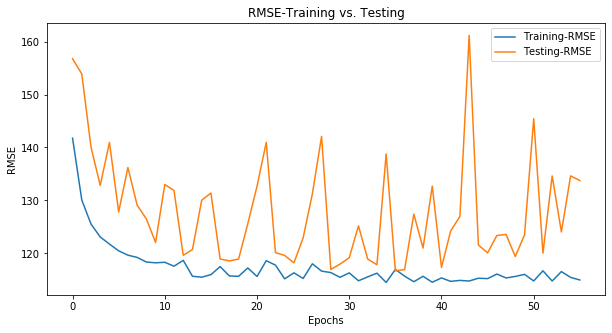

In [6]:
# Fit model
model=create_baseline()
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
history=model.fit(trainX,trainY,epochs=200, verbose=0,
                  validation_data=(testX, testY),
                  batch_size = 1,callbacks=[early_stop])

#Plot
def plot_accuracies_and_losses(history):
    plt.figure(figsize=(10,5)) 
    plt.title('RMSE-Training vs. Testing')
    history2=scaler.inverse_transform(np.array(history.history['loss']).reshape(1, -1))
    history3=scaler.inverse_transform(np.array(history.history['val_loss']).reshape(1, -1))
    plt.plot(history2.ravel())
    plt.plot(history3.ravel())
    plt.legend(['Training-RMSE','Testing-RMSE'], loc='best')
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.show()
    
plot_accuracies_and_losses(history)

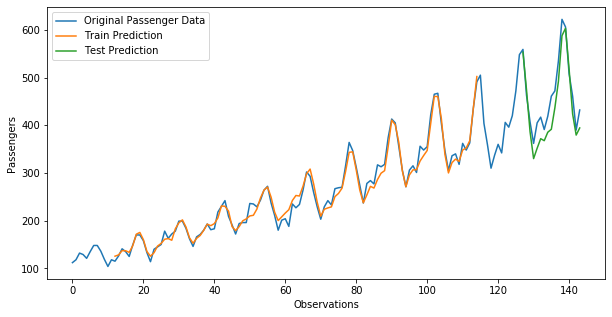

In [7]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

#shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps:len(trainPredict)+n_steps, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(n_steps*2):len(dataset), :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (10, 5))
plt.plot(scaler.inverse_transform(dataset), label='Original Passenger Data')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.xlabel('Observations')
plt.ylabel('Passengers')
plt.legend(loc='best')
plt.show()

In [8]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(scaler.inverse_transform(trainY), trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(scaler.inverse_transform(testY), testPredict[:,0]))
print('RMSE Metrics')
print('Train RMSE: {:.2f}, Validation RMSE: {:.2f}'.format(trainScore,testScore)) 

RMSE Metrics
Train RMSE: 11.46, Validation RMSE: 34.52
